In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 0
import scipy
#from numpy.linalg import svd


import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), 'Documents/git/Xct'))

    from scTenifoldXct.main import *
    import scTenifoldXct.dNN as dNN    
    import scTenifoldXct.visualization as vis
    
except ImportError:
    print('Module not found')

In [3]:
ada = sc.read_h5ad("../data/LS_processed.h5ad")
ada

AnnData object with n_obs × n_vars = 5011 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient.id', 'condition', 'labels', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    layers: 'log1p', 'raw'

## create a Xct_metrics obj:

In [ ]:
skin = Xct_metrics(ada)
type(skin)

In [ ]:
skin.LRs.head()

In [ ]:
skin._genes_index_DB

In [ ]:
ada.var_names[1194-1] #check

In [ ]:
#skin.chen2016_fit(ada, plot = True, verbose = True)

## create a Xct obj with GRN building:

In [4]:
obj1 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = False, pcNet_name = 'skin_net', verbose = True)

print(obj1)

init an Xct object for interactions from Inflam. FIB (484) to Inflam. DC (81)...
loading GRNs...
building correspondence...
init completed.

Xct object for interactions from Inflam. FIB (484) to Inflam. DC (81)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [5]:
df1 = obj1.fill_metric()
df1

,ligand,receptor,mean_L,mean_R,var_L,var_R
18,IGF1,NTRK2,0.029522,0.024446,0.067410,0.027285
28,AREG,NTRK2,0.003443,0.024446,0.005726,0.027285
33,FGF2,NTRK2,0.076530,0.024446,0.142827,0.027285
35,FGF7,NTRK2,0.449156,0.024446,0.835224,0.027285
53,BDNF,NTRK2,0.009386,0.024446,0.016305,0.027285
...,...,...,...,...,...,...
7884,LAMB1,SV2B,0.192922,0.015761,0.356617,0.019873
7890,LAMC3,SV2B,0.343355,0.015761,0.610706,0.019873
7894,LAMB2,SV2B,1.027162,0.015761,1.343443,0.019873
8023,FSTL1,DIP2A,1.154967,0.066773,1.490066,0.086209


## mode 'full':

In [6]:
counts_np1 = get_counts_np(obj1)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape

(2, (3000, 484), (3000, 81))

In [7]:
projections, losses = dNN.train_and_project(counts_np1, obj1._w, dim = 3, steps = 1000, lr = 0.001)

Net(
  (linear1): Linear(in_features=484, out_features=152, bias=True)
  (linear2): Linear(in_features=152, out_features=38, bias=True)
  (linear3): Linear(in_features=38, out_features=3, bias=True)
)
Net(
  (linear1): Linear(in_features=81, out_features=60, bias=True)
  (linear2): Linear(in_features=60, out_features=15, bias=True)
  (linear3): Linear(in_features=15, out_features=3, bias=True)
)
1 79829.3359375
10 35266.80078125
20 16415.2890625
30 12733.5849609375
40 10159.7470703125
50 8625.986328125
60 7610.19140625
70 7067.31103515625
80 6663.28662109375
90 6349.14013671875
100 6077.306640625
110 5842.671875
120 5631.521484375
130 5438.982421875
140 5263.544921875
150 5104.31298828125
160 4961.521484375
170 4836.76513671875
180 5063.28759765625
190 4689.4091796875
200 4590.3681640625
210 4527.8974609375
220 4469.18603515625
230 4419.4931640625
240 4373.83203125
250 4332.21337890625
260 4295.3271484375
270 4261.1396484375
280 4229.611328125
290 4200.5205078125
300 4180.06201171875
3

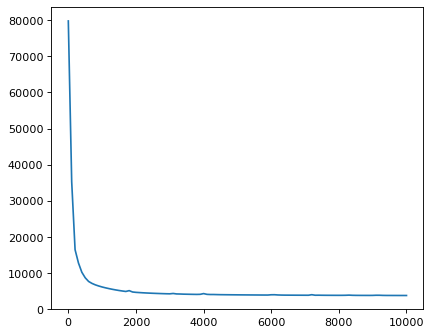

In [8]:
plot_nn_loss(losses)

In [9]:
obj1._net_A.shape, obj1._net_B.shape, obj1._w.shape #check

((3000, 3000), (3000, 3000), (6000, 6000))

In [10]:
w12 = obj1._w[:obj1._net_A.shape[0], obj1._net_A.shape[1]:]

np.mean(w12)  #check

1.0002169791476765

In [11]:
#selected LR pairs
candidates = get_candidates(df1)
print(len(candidates))
candidates[:5]

160


['IGF1_NTRK2', 'AREG_NTRK2', 'FGF2_NTRK2', 'FGF7_NTRK2', 'BDNF_NTRK2']

In [ ]:
# np.savetxt("./data/skin_projections_pair.csv", projections, delimiter="\t")

# projections = np.genfromtxt("./data/skin_projections_pair.csv", delimiter="\t")

In [12]:
projections.shape

(6000, 3)

In [13]:
df_nn = nn_aligned_dist(obj1, projections, dist_metric = 'euclidean') # euclidean, mahalanobis
df_nn

computing pair-wise euclidean distances...
adding column 'correspondence'...


,ligand,receptor,dist,correspondence
FAM89A_FAM89A,FAM89A,FAM89A,0.035963,0.000000
FAM89A_BCL2L15,FAM89A,BCL2L15,0.035963,0.000000
FAM89A_NABP1,FAM89A,NABP1,0.011163,1.600263
FAM89A_SPTBN1,FAM89A,SPTBN1,0.033493,0.017211
FAM89A_SNHG9,FAM89A,SNHG9,0.018331,0.158875
...,...,...,...,...
CFD_MMP12,CFD,MMP12,0.002088,818.382740
CFD_HLA-DRA,CFD,HLA-DRA,0.001719,3037.144373
CFD_CCL1,CFD,CCL1,0.022168,3.832711
CFD_IBSP,CFD,IBSP,0.024532,0.000000


In [ ]:
plt.hist(df_nn['dist'], bins=1000)
plt.show()

In [ ]:
# df_enriched = chi2_test(df_nn, df=3, pval=0.05, FDR=True, candidates = candidates, plot=True)

# df_enriched


Total enriched: 24 / 9000000


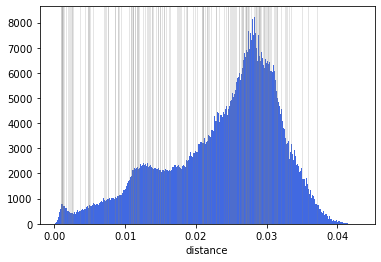

,ligand,receptor,dist,correspondence,p_val,enriched_rank
CCL2_CCR7,CCL2,CCR7,0.000950,311.432610,0.002328,1
CCL19_CCR7,CCL19,CCR7,0.000983,594.184752,0.002558,2
CCL2_CXCR4,CCL2,CXCR4,0.001018,220.004351,0.002825,3
VCAM1_ITGB2,VCAM1,ITGB2,0.001040,65.192753,0.002986,4
CCL19_CXCR4,CCL19,CXCR4,0.001113,419.748050,0.003523,5
CXCL12_CCR7,CXCL12,CCR7,0.001132,325.515984,0.003661,6
CXCL12_CXCR4,CXCL12,CXCR4,0.001193,229.953224,0.004125,7
CXCL14_CCR7,CXCL14,CCR7,0.001273,557.672720,0.004699,8
CXCL14_CXCR4,CXCL14,CXCR4,0.001362,393.954971,0.005312,9
CCL26_CCR7,CCL26,CCR7,0.001650,50.003673,0.007184,10


In [15]:
df_enriched = null_test(df_nn, candidates, pct = 0.025, plot=True)
df_enriched

In [ ]:
#check corr
select = df_nn['correspondence'] != 0
nX = np.asarray(df_nn['correspondence'][select])
nY = np.asarray(df_nn['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [ ]:
# df_nn_filtered = filtered_nn_aligned_dist(df_nn, candidates)
# df_nn_filtered.head()

In [ ]:
# df_enriched.to_excel('LS_skin_FIB2DC.xlsx')

#### GSEA:

In [16]:
genelist = get_genelist(df_enriched)
len(genelist)

17

In [18]:
import gseapy as gp

enr = gp.enrichr(gene_list= list(genelist),
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human', 
                 outdir=None, #'enrichr_kegg',
                 no_plot=True,
                 cutoff=0.05 
                )

In [19]:
enr.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,cellular response to cytokine stimulus (GO:007...,12/482,1.859200e-16,1.308877e-13,0,0,99.640851,3609.112712,VCAM1;CXCL12;ITGB2;CXCR4;CCL2;CXCL1;CCR7;CCL19...
1,GO_Biological_Process_2021,inflammatory response (GO:0006954),9/230,6.746714e-14,2.374843e-11,0,0,100.598416,3050.861830,ITGB2;CXCR4;CCL2;CXCL1;CCR7;CCL19;TNF;CXCL2;CCL26
2,GO_Biological_Process_2021,chemokine-mediated signaling pathway (GO:0070098),6/56,4.416997e-12,1.036522e-09,0,0,217.450909,5685.376010,CXCL12;CCL2;CXCL1;CCL19;CXCL2;CCL26
3,GO_Biological_Process_2021,cellular response to chemokine (GO:1990869),6/60,6.797886e-12,1.196428e-09,0,0,201.303030,5176.388542,CXCL12;CCL2;CXCL1;CCL19;CXCL2;CCL26
4,GO_Biological_Process_2021,cytokine-mediated signaling pathway (GO:0019221),10/621,1.239042e-11,1.744571e-09,0,0,45.293430,1137.503619,VCAM1;CXCL12;ITGB2;CCL2;CXCL1;CCL19;TNF;CXCL2;...
5,GO_Biological_Process_2021,neutrophil chemotaxis (GO:0030593),6/70,1.771995e-11,2.079141e-09,0,0,169.764205,4202.738623,ITGB2;CCL2;CXCL1;CCL19;CXCL2;CCL26
6,GO_Biological_Process_2021,granulocyte chemotaxis (GO:0071621),6/73,2.297370e-11,2.310498e-09,0,0,162.138399,3971.851016,ITGB2;CCL2;CXCL1;CCL19;CXCL2;CCL26
7,GO_Biological_Process_2021,neutrophil migration (GO:1990266),6/77,3.193713e-11,2.810467e-09,0,0,152.973111,3696.939712,ITGB2;CCL2;CXCL1;CCL19;CXCL2;CCL26
8,GO_Biological_Process_2021,dendritic cell chemotaxis (GO:0002407),4/16,6.457516e-10,5.051213e-08,0,0,512.076923,10835.858089,CXCR4;CCR7;CCL19;CCR6
9,GO_Biological_Process_2021,dendritic cell migration (GO:0036336),4/18,1.084596e-09,7.635557e-08,0,0,438.879121,9059.368343,CXCR4;CCR7;CCL19;CCR6


In [ ]:
# enr.results.to_excel('LS_enrichr_FIB2DC.xlsx')

#### visualization:

In [49]:
Xct.add_names_to_nets(obj1)

completed.


In [50]:
targets = vis.get_Xct_pairs(df_enriched)
targets

(['CCL2', 'CCR7'],
 ['CCL19', 'CCR7'],
 ['CCL2', 'CXCR4'],
 ['VCAM1', 'ITGB2'],
 ['CCL19', 'CXCR4'],
 ['CXCL12', 'CCR7'],
 ['CXCL12', 'CXCR4'],
 ['CXCL14', 'CCR7'],
 ['CXCL14', 'CXCR4'],
 ['CCL26', 'CCR7'],
 ['CCL26', 'CXCR4'],
 ['CXCL2', 'CCR7'],
 ['CXCL1', 'CCR7'],
 ['CXCL2', 'CXCR4'],
 ['CTGF', 'ITGB2'],
 ['CXCL1', 'CXCR4'],
 ['CCL2', 'TNF'],
 ['CYR61', 'ITGB2'],
 ['DCN', 'VEGFA'],
 ['CXCL14', 'CCR6'],
 ['CCL2', 'VEGFA'],
 ['CCL19', 'CCR6'],
 ['CXCL12', 'CCR6'],
 ['CCL2', 'CCR6'])

In [ ]:
# vis.plot_pcNet(obj1, view='sender', gene_names=['CCL19', 'CXCL12'], top_edges=40, show = True, verbose = True)

In [ ]:
# vis.plot_pcNet(obj1, view='receiver', gene_names=['CCR7', 'CXCR4'], top_edges=40, show = True, verbose = True)

In [51]:
scale_factor = 10

identified 217 TF(s) along with 2 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 32, # of edges: 40

identified 217 TF(s) along with 2 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 31, # of edges: 40

graphs merged: 
# of nodes: 63, # of edges: 80

edge from CCL19 to CCR7 added
edge from CXCL12 to CXCR4 added
graph saved as "LS_FIB2DC.png"


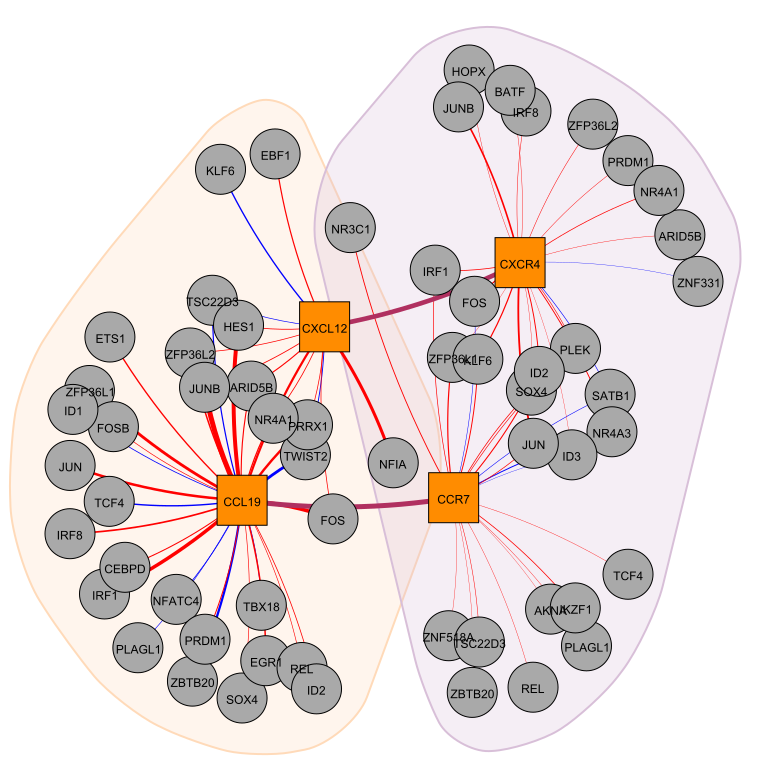

In [52]:
g1 = vis.plot_pcNet(obj1, view='sender', gene_names=['CCL19', 'CXCL12'], top_edges=40, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', gene_names=['CCR7', 'CXCR4'], top_edges=40, show = False, verbose = True)
vis.plot_XNet(g1, g2, Xct_pair = [['CCL19', 'CCR7'], ['CXCL12', 'CXCR4']], df_enriched=df_enriched,
              verbose = True, edge_width_scale=scale_factor, 
              mark_color = ["peachpuff", "thistle"])
#                saveas='LS_FIB2DC')

identified 216 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 216 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

graphs merged: 
# of nodes: 42, # of edges: 40

edge from CXCL2 to CXCR4 added
41


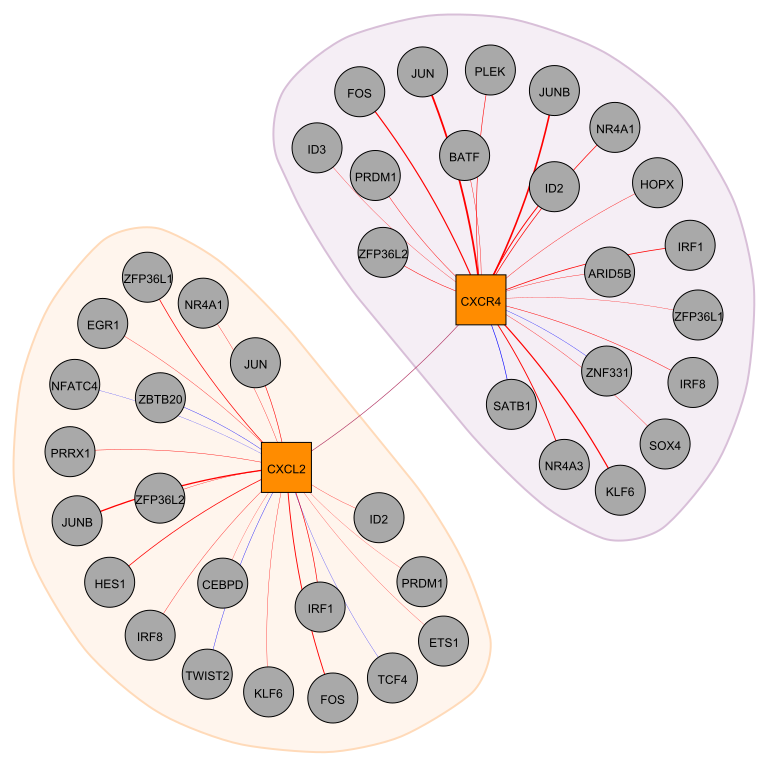

In [25]:
a = 13

g1 = vis.plot_pcNet(obj1, view='sender', gene_names=[targets[a][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', gene_names=[targets[a][1]], top_edges=20, show = False, verbose = True)
vis.plot_XNet(g1, g2, Xct_pair = [targets[a]], verbose = True, df_enriched = df_enriched, edge_width_scale=scale_factor, 
              mark_color = ["peachpuff", "thistle"])

### Inflam.DC to Inflam. TC:

In [26]:
# obj11 = Xct(ada, 'Inflam. DC', 'Inflam. TC', build_GRN = True, save_GRN = True,
#            pcNet_name = 'net_DC2TC_LS', mode = 'full', verbose = True)

obj11 = Xct(ada, 'Inflam. DC', 'Inflam. TC', build_GRN = False,
           pcNet_name = 'net_DC2TC_LS', verbose = True)
print(obj11)

init an Xct object for interactions from Inflam. DC (81) to Inflam. TC (266)...
loading GRNs...
building correspondence...
init completed.

Xct object for interactions from Inflam. DC (81) to Inflam. TC (266)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [27]:
df11 = obj11.fill_metric()
df11

,ligand,receptor,mean_L,mean_R,var_L,var_R
18,IGF1,NTRK2,0.015782,0.188672,0.019926,0.382669
28,AREG,NTRK2,0.302649,0.188672,0.695448,0.382669
40,EFNA1,NTRK2,0.040046,0.188672,0.071560,0.382669
56,VEGFA,NTRK2,0.264259,0.188672,0.576541,0.382669
198,CD8A,LAT,0.016989,0.746377,0.023090,1.278990
...,...,...,...,...,...,...
7370,CXCL8,LPAR2,0.834715,0.057883,2.376544,0.159946
7703,IL32,PTGER1,1.086030,0.014364,1.565225,0.054677
7882,PCSK1N,GPR171,0.015782,0.582902,0.019926,1.139179
7920,CLEC2D,KLRB1,0.077279,0.373006,0.140790,1.048742


In [28]:
#selected LR pairs
candidates11 = get_candidates(df11)
print(len(candidates11))
candidates11[:5]

231


['IGF1_NTRK2', 'AREG_NTRK2', 'EFNA1_NTRK2', 'VEGFA_NTRK2', 'CD8A_LAT']

In [29]:
counts_np11 = get_counts_np(obj11)
len(counts_np11), counts_np11[0].shape, counts_np11[1].shape

(2, (3000, 81), (3000, 266))

In [30]:
projections11, losses11 = dNN.train_and_project(counts_np11, obj11._w, dim = 3, steps = 1000, lr = 0.001)

Net(
  (linear1): Linear(in_features=81, out_features=60, bias=True)
  (linear2): Linear(in_features=60, out_features=15, bias=True)
  (linear3): Linear(in_features=15, out_features=3, bias=True)
)
Net(
  (linear1): Linear(in_features=266, out_features=112, bias=True)
  (linear2): Linear(in_features=112, out_features=28, bias=True)
  (linear3): Linear(in_features=28, out_features=3, bias=True)
)
1 51665.6953125
10 38413.953125
20 20316.60546875
30 16493.34765625
40 13980.48046875
50 12535.794921875
60 11277.3828125
70 9958.65234375
80 8341.048828125
90 7283.509765625
100 6545.05224609375
110 6204.2373046875
120 6321.8701171875
130 6077.861328125
140 5593.1572265625
150 5479.83203125
160 5345.0
170 5229.9453125
180 5137.90283203125
190 5057.31640625
200 4984.80126953125
210 4919.892578125
220 4860.36962890625
230 4805.52587890625
240 4754.57568359375
250 4706.994140625
260 4662.35498046875
270 4620.3271484375
280 4580.64111328125
290 4543.0634765625
300 4783.1787109375
310 4703.2734375


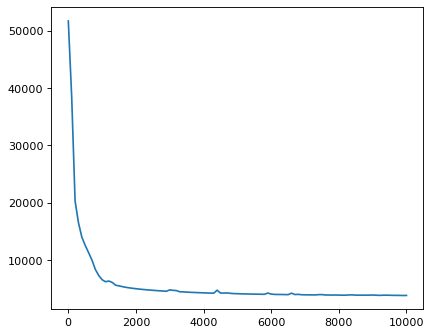

In [31]:
plot_nn_loss(losses11)

In [32]:
df_nn11 = nn_aligned_dist(obj11, projections11)
df_nn11

computing pair-wise euclidean distances...
adding column 'correspondence'...


,ligand,receptor,dist,correspondence
FAM89A_FAM89A,FAM89A,FAM89A,0.028875,0.000000
FAM89A_BCL2L15,FAM89A,BCL2L15,0.029292,0.000000
FAM89A_NABP1,FAM89A,NABP1,0.029091,0.000000
FAM89A_SPTBN1,FAM89A,SPTBN1,0.031457,0.000000
FAM89A_SNHG9,FAM89A,SNHG9,0.030532,0.000000
...,...,...,...,...
CFD_MMP12,CFD,MMP12,0.039248,0.000000
CFD_HLA-DRA,CFD,HLA-DRA,0.010846,1.329666
CFD_CCL1,CFD,CCL1,0.008738,18.420191
CFD_IBSP,CFD,IBSP,0.039248,0.000000


In [ ]:
plt.hist(df_nn11['dist'], bins=1000)
plt.show()

In [ ]:
#check corr
select = df_nn11['correspondence'] != 0
nX = np.asarray(df_nn11['correspondence'][select])
nY = np.asarray(df_nn11['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [ ]:
df_enriched11 = chi2_test(df_nn11, df=3, pval=0.05, FDR=True, candidates = candidates11, plot=True)

df_enriched11


Total enriched: 16 / 9000000


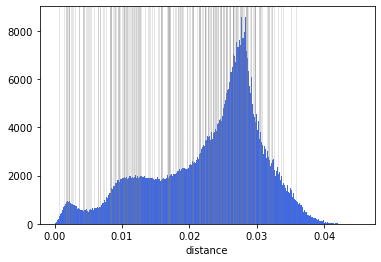

,ligand,receptor,dist,correspondence,p_val,enriched_rank
CXCL8_CXCR4,CXCL8,CXCR4,0.000651,65.741994,0.000704,1
CCL22_CXCR4,CCL22,CXCR4,0.001349,208.066379,0.004191,2
CXCL8_CXCR6,CXCL8,CXCR6,0.001634,43.850745,0.006522,3
CCL17_CCR6,CCL17,CCR6,0.001732,142.785056,0.007397,4
CXCL8_CCR6,CXCL8,CCR6,0.001853,32.993832,0.008529,5
S100A8_CD69,S100A8,CD69,0.001885,108.696947,0.008850,6
CCL22_CCR6,CCL22,CCR6,0.001963,104.421951,0.009627,7
CCL17_CXCR6,CCL17,CXCR6,0.002084,189.769742,0.010807,8
CCL22_CXCR6,CCL22,CXCR6,0.002089,138.782917,0.010868,9
CCL17_CXCR4,CCL17,CXCR4,0.002110,284.506940,0.011056,10


In [34]:
df_enriched11 = null_test(df_nn11, pct=0.025, candidates = candidates11, plot=True)

df_enriched11

In [ ]:
# df_enriched11.to_excel('LS_skin_DC2T.xlsx')

#### GSEA:

In [35]:
genelist11 = get_genelist(df_enriched11)
len(genelist11)

17

In [36]:
import gseapy as gp

enr11 = gp.enrichr(gene_list= list(genelist11),
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human', 
                 outdir=None, #'enrichr_kegg',
                 no_plot=True,
                 cutoff=0.05 
                )

In [37]:
enr11.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,inflammatory response (GO:0006954),7/230,4.280700e-10,2.611227e-07,0,0,62.026906,1338.027936,CXCL8;CCL22;ITGB2;CXCR4;TNF;CCL17;S100A8
1,GO_Biological_Process_2021,neutrophil chemotaxis (GO:0030593),5/70,2.719423e-09,6.746402e-07,0,0,127.679487,2518.202861,CXCL8;CCL22;ITGB2;CCL17;S100A8
2,GO_Biological_Process_2021,granulocyte chemotaxis (GO:0071621),5/73,3.369858e-09,6.746402e-07,0,0,122.028186,2380.574083,CXCL8;CCL22;ITGB2;CCL17;S100A8
3,GO_Biological_Process_2021,neutrophil migration (GO:1990266),5/77,4.423870e-09,6.746402e-07,0,0,115.225694,2216.510374,CXCL8;CCL22;ITGB2;CCL17;S100A8
4,GO_Biological_Process_2021,cellular response to cytokine stimulus (GO:007...,7/482,7.133026e-08,8.702292e-06,0,0,28.748632,473.085905,CXCL8;CCL22;ITGB2;CXCR4;TNFRSF1B;TNF;CCL17
5,GO_Biological_Process_2021,cellular response to tumor necrosis factor (GO...,5/194,4.590379e-07,4.666885e-05,0,0,43.637566,636.852447,CXCL8;CCL22;TNFRSF1B;TNF;CCL17
6,GO_Biological_Process_2021,second-messenger-mediated signaling (GO:0019932),4/89,8.340959e-07,7.268550e-05,0,0,72.028959,1008.183399,CXCL8;CXCR4;CXCR6;CCR6
7,GO_Biological_Process_2021,regulation of ERK1 and ERK2 cascade (GO:0070372),5/238,1.259829e-06,9.606196e-05,0,0,35.318312,479.782828,TGFBR3;CD74;CCL22;TNF;CCL17
8,GO_Biological_Process_2021,calcium-mediated signaling (GO:0019722),4/102,1.441926e-06,9.773053e-05,0,0,62.433281,839.698344,CXCL8;CXCR4;CXCR6;CCR6
9,GO_Biological_Process_2021,lymphocyte migration (GO:0072676),3/40,4.942205e-06,3.014745e-04,0,0,115.517375,1411.356515,CCL22;CCR6;CCL17


In [ ]:
# enr11.results.to_excel('LS_enrichr_DC2T.xlsx')

#### visualization:

In [38]:
Xct.add_names_to_nets(obj11)

completed.


In [39]:
targets = vis.get_Xct_pairs(df_enriched11)
targets

(['CXCL8', 'CXCR4'],
 ['CCL22', 'CXCR4'],
 ['CXCL8', 'CXCR6'],
 ['CCL17', 'CCR6'],
 ['CXCL8', 'CCR6'],
 ['S100A8', 'CD69'],
 ['CCL22', 'CCR6'],
 ['CCL17', 'CXCR6'],
 ['CCL22', 'CXCR6'],
 ['CCL17', 'CXCR4'],
 ['HLA-DMA', 'CD74'],
 ['S100A8', 'ITGB2'],
 ['TNF', 'NR3C1'],
 ['INHBA', 'TGFBR3'],
 ['S100B', 'TNF'],
 ['TNF', 'TNFRSF1B'])

In [ ]:
vis.plot_pcNet(obj11, view='sender', gene_names = [targets[1][0], targets[2][0], targets[5][0]], 
               top_edges=30, show = True, verbose = True)

In [40]:
scale_factor = 10

identified 217 TF(s) along with 3 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 30

identified 217 TF(s) along with 3 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 23, # of edges: 30

graphs merged: 
# of nodes: 44, # of edges: 60

edge from CCL17 to CCR6 added
edge from CCL22 to CCR6 added
edge from CCL17 to CXCR4 added
graph saved as "LS_DC2T.png"


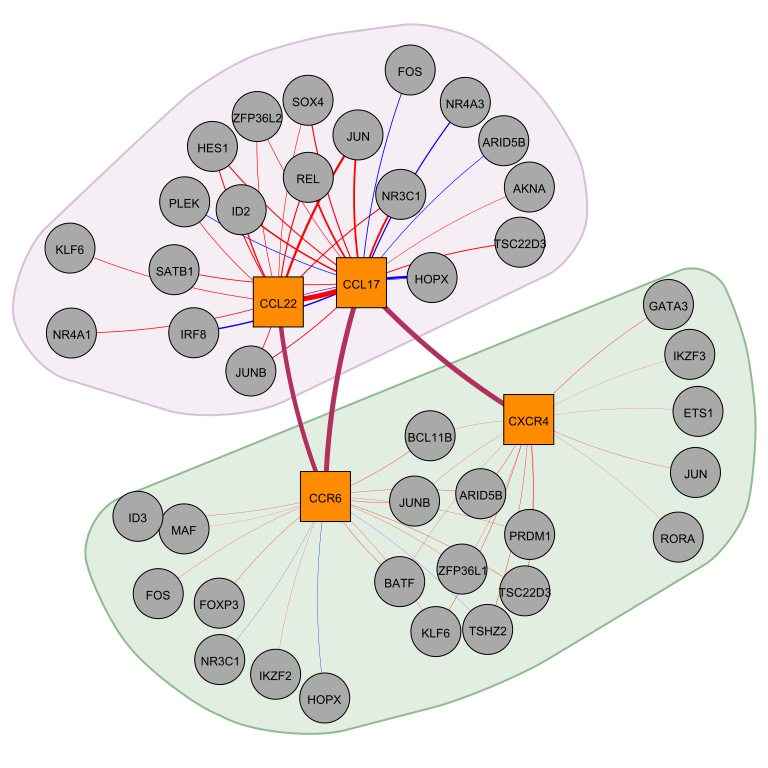

In [48]:
g1 = vis.plot_pcNet(obj11, view='sender', gene_names=[targets[3][0], targets[6][0], targets[9][0]], 
                    top_edges=30, show = False, verbose = True)
g2 = vis.plot_pcNet(obj11, view='receiver', gene_names=[targets[3][1], targets[6][1], targets[9][1]], 
                    top_edges=30, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[3], targets[6], targets[9]], 
              df_enriched = df_enriched11, verbose = True, edge_width_scale=scale_factor, 
              mark_color = ["thistle", '#8FBC8F'])
# , saveas='LS_DC2T')

identified 216 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 216 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

graphs merged: 
# of nodes: 42, # of edges: 40

edge from CXCL8 to CCR6 added


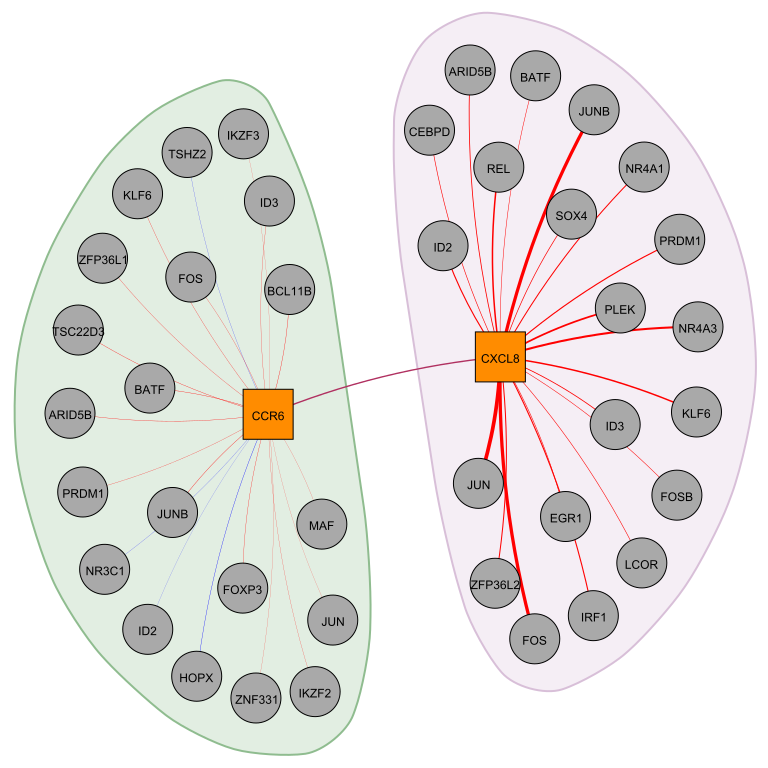

In [43]:
a = 4

g1 = vis.plot_pcNet(obj11, view='sender', gene_names=[targets[a][0]], 
                    top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj11, view='receiver', gene_names=[targets[a][1]], 
                    top_edges=20, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[a]], verbose = True, edge_width_scale=scale_factor, 
              mark_color = ["thistle", '#8FBC8F'], df_enriched = df_enriched11)
#               , saveas = 'LS_DC2T_CXCL8')